<a href="https://colab.research.google.com/github/flohmannjr/Carvana-Predict-Car-Prices/blob/main/Carvana_Predict_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carvana - Predict Car Prices

https://www.kaggle.com/datasets/ravishah1/carvana-predict-car-prices

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

In [3]:
SEED = 2008193

In [4]:
def get_metrics(y_test, y_pred):

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return {'Mean Absolute Error': mae,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Percentage Error': mape}

# Data

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/Carvana-Predict-Car-Prices/main/carvana.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    22000 non-null  object
 1   Year    22000 non-null  int64 
 2   Miles   22000 non-null  int64 
 3   Price   22000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 687.6+ KB


## Preprocessing

In [7]:
df['Year'] = df['Year'].astype(str).str[:4].astype(int)

In [8]:
df.duplicated().sum()

12682

**More than half of the data is duplicated (12682/22000). If not fixed, the models will overfit.**

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
name = df['Name'].str.split()

df['Brand'] = name.str[0]
df['Model'] = name.str[1:].str.join(' ')

In [11]:
df['Milage_Group'] = (np.ceil(df['Miles'] / 4000) * 4000).astype(int)

In [12]:
df.drop('Name', axis=1, inplace=True)

## Checking

In [13]:
df.sample(5)

,Year,Miles,Price,Brand,Model,Milage_Group
14428,2018,41626,18990,Ford,Escape,44000
3429,2021,26956,27990,Kia,Niro,28000
8691,2021,18452,19590,Nissan,Versa,20000
11203,2015,80176,15990,FIAT,Abarth,84000
9995,2015,63932,20990,Toyota,Camry,64000


In [14]:
df['Year'].value_counts()

2016    1077
2017    1075
2015     977
2018     968
2019     941
2020     907
2021     817
2014     810
2013     638
2012     440
2022     278
2011     202
2010     133
2009      52
2023       3
Name: Year, dtype: int64

# Analysis

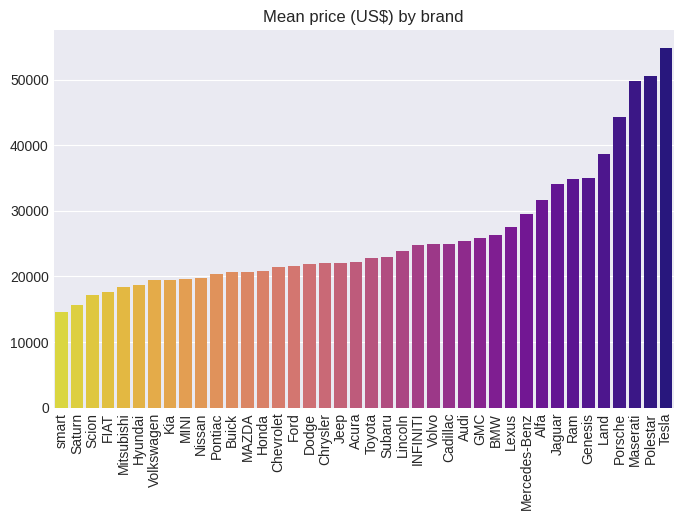

In [15]:
df_mean_prices_by_brand = df[['Brand', 'Price']].groupby(by='Brand').mean().sort_values(by='Price').T

sns.barplot(data=df_mean_prices_by_brand, palette='plasma_r')

plt.title('Mean price (US$) by brand')
plt.xlabel('')
plt.ylabel('')

plt.xticks(rotation=90);

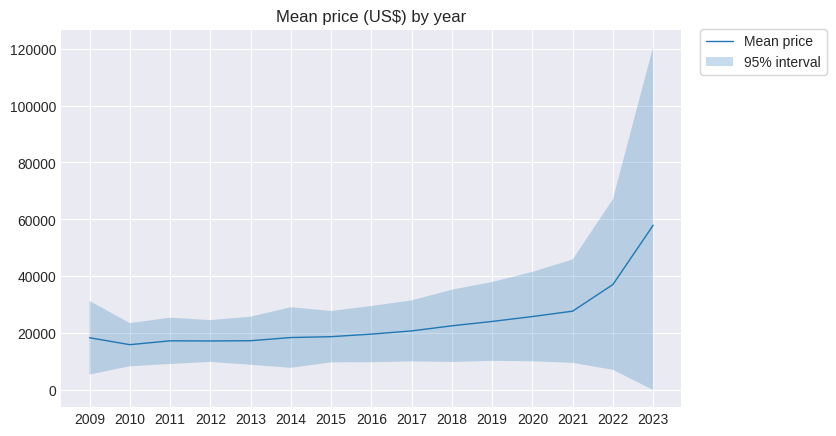

In [16]:
df_prices_by_year = df[['Year', 'Price']].groupby(by='Year').agg(['mean', 'std']).sort_index()

df_prices_by_year.columns = ['_'.join(col).strip() for col in df_prices_by_year.columns.values]

df_prices_by_year.reset_index(inplace=True)
df_prices_by_year.fillna(0, inplace=True)

df_prices_by_year['Price_interval'] = df_prices_by_year['Price_std'] * 1.96  # https://en.wikipedia.org/wiki/1.96
df_prices_by_year['Price_upper']    = df_prices_by_year['Price_mean'] + df_prices_by_year['Price_interval']
df_prices_by_year['Price_lower']    = np.maximum(df_prices_by_year['Price_mean'] - df_prices_by_year['Price_interval'], 0)

# display(df_prices_by_year)

sns.lineplot(data=df_prices_by_year, x='Year', y='Price_mean', linewidth=1, label='Mean price')
plt.fill_between(data=df_prices_by_year, x='Year', y1='Price_lower', y2='Price_upper', alpha=0.25, label='95% interval')

plt.title('Mean price (US$) by year')
plt.xlabel('')
plt.ylabel('')

plt.xticks(df_prices_by_year['Year'])

plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white');

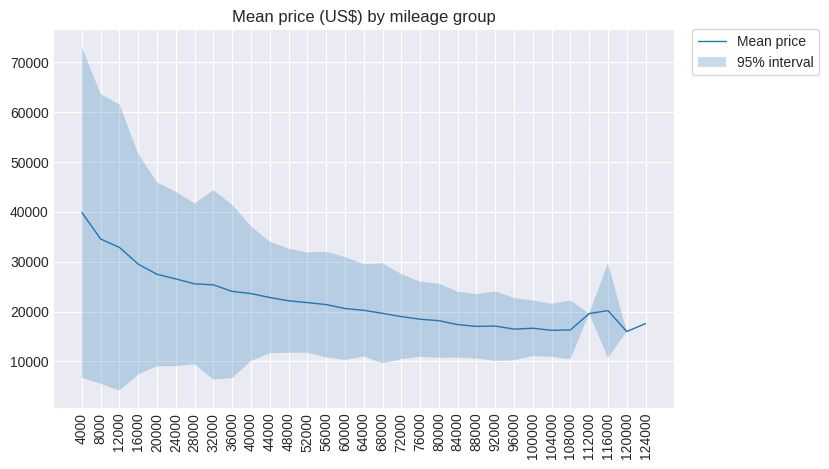

In [17]:
df_prices_by_mileage_group = df[['Milage_Group', 'Price']].groupby(by='Milage_Group').agg(['mean', 'std']).sort_index()

df_prices_by_mileage_group.columns = ['_'.join(col).strip() for col in df_prices_by_mileage_group.columns.values]

df_prices_by_mileage_group.reset_index(inplace=True)
df_prices_by_mileage_group.fillna(0, inplace=True)

df_prices_by_mileage_group['Price_interval'] = df_prices_by_mileage_group['Price_std'] * 1.96
df_prices_by_mileage_group['Price_upper']    = df_prices_by_mileage_group['Price_mean'] + df_prices_by_mileage_group['Price_interval']
df_prices_by_mileage_group['Price_lower']    = np.maximum(df_prices_by_mileage_group['Price_mean'] - df_prices_by_mileage_group['Price_interval'], 0)

# display(df_prices_by_mileage_group)

sns.lineplot(data=df_prices_by_mileage_group, x='Milage_Group', y='Price_mean', linewidth=1, label='Mean price')
plt.fill_between(data=df_prices_by_mileage_group, x='Milage_Group', y1='Price_lower', y2='Price_upper', alpha=0.25, label='95% interval')

plt.title('Mean price (US$) by mileage group')
plt.xlabel('')
plt.ylabel('')

plt.xticks(df_prices_by_mileage_group['Milage_Group'], rotation=90)

plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white');

# Regression model

## Train and test split and scaling

In [18]:
df.drop('Milage_Group', axis=1, inplace=True)

df['Brand'] = df['Brand'].astype('category').cat.codes
df['Model'] = df['Model'].astype('category').cat.codes

In [19]:
X = df.drop('Price', axis=1)
y = df['Price']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Model

In [22]:
%%time

model = RandomForestRegressor(n_estimators=200, bootstrap=True, oob_score=True, warm_start=True, random_state=SEED)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrics = get_metrics(y_test, y_pred)

CPU times: user 5.66 s, sys: 104 ms, total: 5.76 s
Wall time: 7.64 s


In [23]:
metrics

{'Mean Absolute Error': 2197.1060539610157,
 'Root Mean Squared Error': 4332.780607510014,
 'Mean Absolute Percentage Error': 0.09135459673995282}